In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import six
project_path = os.getcwd() + '/../'
sys.path.append(project_path + "utils")

import sklearn.metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.grid_search import GridSearchCV
import sklearn
from sklearn.externals import joblib
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

import function
import preprocessing
import local_bayes
import visualize
import metrics

In [3]:
sys.path.append(project_path + "models/cnn")
import cnn

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import collections

sys.path.append(project_path + "Python-ELM")

import bayes_logistic as bl
import copy as copy

In [16]:
import tarfile
import gzip
import csv

# data load

In [ ]:
def parse(data):
    lines = data.split('\n')
    lines = filter(lambda x: x.strip() != '', lines)
    nlines = len(lines)
    X = np.zeros((nlines, 784) , dtype=float)
    Y = np.zeros((nlines, ) , dtype=float)
 
    for n, line in enumerate(lines):
        line = line.strip()
        if line != '':
            parts = line.strip().split(' ')
            for pair in parts[1:]:
                pos, val = pair.strip().split(':')
                pos, val = int(pos), float(val)
                X[n, pos] = float(val)
            Y[n] = parts[0]
    return X, Y
 
X_train, Y_train = parse(train)
X_test, Y_test = parse(test)

In [21]:
file = project_path + 'original_data/inf_mnist/test10k-patterns.gz'
test_x = gzip.open(file, 'r')

In [22]:
for i, test_x_p in enumerate(test_x):
    if i < 100:
        print test_x_p
    else:
        break

    '                                                                                                                                                                                                                T���<$                      �������������ƪ4            CrHr������������                 BCCC;��j                        S��                       ��S                        ���,                       ;��>                        ���                       	��:                        ~��                        K��9                       ���                       ���#                       &��M                       ��s                       ���4                       =���4                       y���(                       y��                                                                                                                                        t}����]                    ��������                  ����Վ���z                 4���  ���                

In [ ]:
train_x, test_x = [], []
train_y, test_y = numpy.array([]), numpy.array([])
for i, higgs_p in enumerate(higgs):
    if i < 10000000:
        train_x.append(higgs_p[1:22])
        train_y = numpy.append(train_y, higgs_p[0])
    else:
        test_x.append(higgs_p[1:22])
        test_y = numpy.append(test_y, higgs_p[0])

train_x = numpy.array(train_x)
test_x = numpy.array(test_x)

In [24]:
train_x.shape

(10000, 21)

In [25]:
test_x.shape

(2000, 21)

In [26]:
train_y.shape

(10000,)

In [27]:
test_y.shape

(2000,)

In [29]:
test_y

array([ 0.,  0.,  0., ...,  1.,  1.,  0.])

## prediction

## logistic regression

### elm

### bayesian logistic regression 2クラス 動作確認

### 全データ

In [19]:
labels_ls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# lr = LogisticRegression(C=0.01, penalty='l2')
# lr.fit(train_x, train_y)

# br = linear_model.BayesianRidge()
# br.fit(train_x, train_y)

elmc = ELMClassifier(n_hidden=1000,
                        alpha=0.93,
                        activation_func='multiquadric',
                        regressor=linear_model.Ridge(),
                        random_state=21398023)
elmc.fit(train_x, train_y)

cor_lr, cor_br, cor_elm = 0, 0, 0
i, sum = 0, 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    if lr.predict(numpy.array([x]))[0] == t:
        cor_lr += 1
        
#     min_dist = 100000000000000000
#     for label in labels_ls:
#         if min_dist > abs(label - br.predict(x)):
#             min_dist = abs(label - br.predict(x))
#             pred_br = label
#     if pred_br == t:
#         cor_br += 1
        
    if elmc.predict(numpy.array([x]))[0] == t:
        cor_elm += 1
        
    sum += 1.0
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
    i += 1

print "logi: %s" % (cor_lr / sum)
print "bayesian logi: %s" % (cor_br / sum)
print "elm: %s" % (cor_elm / sum)

999logi: 0.896
bayesian logi: 0.0
elm: 0.938


### 近傍数100

In [17]:
nn_num=100 ## 適当
data_dim=train_x.shape[1]
max_dist=0
metric='euclidean'
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist, metric=metric, train=train_x)

In [22]:
correct, correct_knn, correct_lr, correct_br, correct_elm, sum = 0, 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, [x])
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## 2クラス分類に
        count_label_dict = collections.Counter(nn_label_array)
        label_1 = count_label_dict.most_common(2)[0][0]
        label_0 = count_label_dict.most_common(2)[1][0]

        new_nn_train_ls, new_nn_label_array = [], numpy.array([])
        for nn_train, nn_label in zip(nn_train_array, nn_label_array):
            if nn_label == label_1:
                new_nn_train_ls.append(nn_train.tolist())
                new_nn_label_array = numpy.append(new_nn_label_array, 1)
            elif nn_label == label_0:
                new_nn_train_ls.append(nn_train.tolist())
                new_nn_label_array = numpy.append(new_nn_label_array, 0)
            else:
                continue
        new_nn_train_array = numpy.array(new_nn_train_ls)
    
        ## kNN
        count_dict = collections.Counter(new_nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
#         print "kNN: %s" % pred_knn

        if abs(pred_knn - 1) < 0.1:
            pred_knn = label_1
        else:
            pred_knn = label_0
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(new_nn_train_array, new_nn_label_array) 
        pred_lr = int(lr.predict([x])[0])
#         print "logi: %s" % pred_lr

        if abs(pred_lr - 1) < 0.1:
            pred_lr = label_1
        else:
            pred_lr = label_0
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian logistic regressions
        
        # Set the number of data points and variables
        N = new_nn_train_array.shape[0]
        p = new_nn_train_array.shape[1]
        # randomly permute the data
        r = np.random.permutation(N)
        X = new_nn_train_array[r,:]
        y = new_nn_label_array[r]
        idx = np.arange(int(N/10))
        
        w_prior = np.zeros(p)
        H_prior = np.diag(np.ones(p))*0.001
        
        w_posterior, H_posterior = bl.fit_bayes_logistic(y[idx], X[idx, :], w_prior, H_prior)
        
        # Now make this posterior our new prior
        w_prior = copy.copy(w_posterior)
        H_prior = copy.copy(H_posterior)
        
        # get the logistic and moderated logistic probabilities
        test_p = np.array([x])
        bayes_prob_lin = bl.bayes_logistic_prob(test_p,w_posterior,H_posterior)
        
        if bayes_prob_lin[0] > 0.50:
            pred_br = label_1
        else:
            pred_br = label_0

        if pred_br == t:
            correct_br += 1.0
        
        ## extreme learning machine
        elmc = ELMClassifier(n_hidden=1000,
                        alpha=0.93,
                        activation_func='multiquadric',
                        regressor=linear_model.Ridge(),
                        random_state=21398023)
        elmc.fit(new_nn_train_array, new_nn_label_array)
        
        if abs(elmc.predict(numpy.array([x]))[0] - 1.0) < 0.1:
            pred_elm = label_1
        else:
            pred_elm = label_0
        
        if pred_elm == t:
            correct_elm += 1.0
            
    sum += 1.0
    
#     if i % 10 == 0 & i != 0:
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
print "bayesian logi result: %s" % ((correct_br + correct) / sum)
print "elm: %s" % (correct_elm / sum)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

### 近傍数500

In [14]:
nn_num=500 ## 適当
data_dim=train_x.shape[1]
max_dist=0
metric='euclidean'
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist, metric=metric, train=train_x)

In [ ]:
correct, correct_knn, correct_lr, correct_br, correct_elm, sum = 0, 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, [x])
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## 2クラス分類に
        count_label_dict = collections.Counter(nn_label_array)
        label_1 = count_label_dict.most_common(2)[0][0]
        label_0 = count_label_dict.most_common(2)[1][0]

        new_nn_train_ls, new_nn_label_array = [], numpy.array([])
        for nn_train, nn_label in zip(nn_train_array, nn_label_array):
            if nn_label == label_1:
                new_nn_train_ls.append(nn_train.tolist())
                new_nn_label_array = numpy.append(new_nn_label_array, 1)
            elif nn_label == label_0:
                new_nn_train_ls.append(nn_train.tolist())
                new_nn_label_array = numpy.append(new_nn_label_array, 0)
            else:
                continue
        new_nn_train_array = numpy.array(new_nn_train_ls)
    
        ## kNN
        count_dict = collections.Counter(new_nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
#         print "kNN: %s" % pred_knn

        if abs(pred_knn - 1) < 0.1:
            pred_knn = label_1
        else:
            pred_knn = label_0
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(new_nn_train_array, new_nn_label_array) 
        pred_lr = int(lr.predict([x])[0])
#         print "logi: %s" % pred_lr

        if abs(pred_lr - 1) < 0.1:
            pred_lr = label_1
        else:
            pred_lr = label_0
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian logistic regressions
        
        # Set the number of data points and variables
        N = new_nn_train_array.shape[0]
        p = new_nn_train_array.shape[1]
        # randomly permute the data
        r = np.random.permutation(N)
        X = new_nn_train_array[r,:]
        y = new_nn_label_array[r]
        idx = np.arange(int(N/10))
        
        w_prior = np.zeros(p)
        H_prior = np.diag(np.ones(p))*0.001
        
        w_posterior, H_posterior = bl.fit_bayes_logistic(y[idx], X[idx, :], w_prior, H_prior)
        
        # Now make this posterior our new prior
        w_prior = copy.copy(w_posterior)
        H_prior = copy.copy(H_posterior)
        
        # get the logistic and moderated logistic probabilities
        test_p = np.array([x])
        bayes_prob_lin = bl.bayes_logistic_prob(test_p,w_posterior,H_posterior)
        
        if bayes_prob_lin[0] > 0.50:
            pred_br = label_1
        else:
            pred_br = label_0

        if pred_br == t:
            correct_br += 1.0
        
        ## extreme learning machine
        elmc = ELMClassifier(n_hidden=1000,
                        alpha=0.93,
                        activation_func='multiquadric',
                        regressor=linear_model.Ridge(),
                        random_state=21398023)
        elmc.fit(new_nn_train_array, new_nn_label_array)
        
        if abs(elmc.predict(numpy.array([x]))[0] - 1.0) < 0.1:
            pred_elm = label_1
        else:
            pred_elm = label_0
        
        if pred_elm == t:
            correct_elm += 1.0
            
    sum += 1.0
    
#     if i % 10 == 0 & i != 0:
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
print "bayesian logi result: %s" % ((correct_br + correct) / sum)
print "elm: %s" % (correct_elm / sum)

### 近傍数500

In [28]:
correct, correct_knn, correct_lr, correct_br, sum = 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, x)
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## kNN
        count_dict = collections.Counter(nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
        print "kNN: %s" % pred_knn
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(nn_train_array, nn_label_array) 
        pred_lr = int(lr.predict(x)[0])
        print "logi: %s" % pred_lr
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian ridge regression
#         br = linear_model.BayesianRidge()
#         br.fit(nn_train_array, nn_label_array)
#         pred_br = int(round(br.predict(x)))
#         print "bayesian logi: %s" % pred_br
        
#         if pred_br == t:
#             correct_br += 1.0
            
    sum += 1.0
    
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
# print "bayesian logi result: %s" % ((correct_br + correct) / sum)

kNN: 7
logi: 7
iteration: 0
kNN: 2
logi: 2
iteration: 1
iteration: 2
kNN: 0
logi: 0
iteration: 3
kNN: 4
logi: 4
iteration: 4
kNN: 1
logi: 1
iteration: 5
kNN: 4
logi: 4
iteration: 6
kNN: 9
logi: 9
iteration: 7
kNN: 6
logi: 5
iteration: 8
kNN: 9
logi: 9
iteration: 9
iteration: 10
kNN: 6
logi: 6
iteration: 11
kNN: 9
logi: 9
iteration: 12
iteration: 13
iteration: 14
kNN: 5
logi: 5
iteration: 15
kNN: 9
logi: 9
iteration: 16
kNN: 7
logi: 7
iteration: 17
kNN: 3
logi: 3
iteration: 18
kNN: 4
logi: 4
iteration: 19
kNN: 9
logi: 9
iteration: 20
kNN: 6
logi: 6
iteration: 21
kNN: 6
logi: 6
iteration: 22
kNN: 5
logi: 5
iteration: 23
kNN: 4
logi: 4
iteration: 24
kNN: 0
logi: 0
iteration: 25
kNN: 7
logi: 7
iteration: 26
kNN: 4
logi: 4
iteration: 27
iteration: 28
iteration: 29
kNN: 3
logi: 3
iteration: 30
kNN: 1
logi: 1
iteration: 31
kNN: 3
logi: 3
iteration: 32
kNN: 6
logi: 4
iteration: 33
kNN: 7
logi: 7
iteration: 34
kNN: 2
logi: 2
iteration: 35
kNN: 7
logi: 7
iteration: 36
kNN: 1
logi: 1
iteration: 3

### 近傍数1000

In [31]:
nn_num=1000 ## 適当
data_dim=train_x.shape[1]
max_dist=0
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist)

In [32]:
correct, correct_knn, correct_lr, correct_br, sum = 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, x)
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## kNN
        count_dict = collections.Counter(nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
        print "kNN: %s" % pred_knn
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(nn_train_array, nn_label_array) 
        pred_lr = int(lr.predict(x)[0])
        print "logi: %s" % pred_lr
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian ridge regression
#         br = linear_model.BayesianRidge()
#         br.fit(nn_train_array, nn_label_array)
#         pred_br = int(round(br.predict(x)))
#         print "bayesian logi: %s" % pred_br
        
#         if pred_br == t:
#             correct_br += 1.0
            
    sum += 1.0
    
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
# print "bayesian logi result: %s" % ((correct_br + correct) / sum)

kNN: 7
logi: 7
iteration: 0
kNN: 2
logi: 2
iteration: 1
kNN: 1
logi: 1
iteration: 2
kNN: 0
logi: 0
iteration: 3
kNN: 4
logi: 4
iteration: 4
kNN: 1
logi: 1
iteration: 5
kNN: 4
logi: 4
iteration: 6
kNN: 9
logi: 9
iteration: 7
kNN: 6
logi: 5
iteration: 8
kNN: 9
logi: 9
iteration: 9
kNN: 0
logi: 0
iteration: 10
kNN: 6
logi: 6
iteration: 11
kNN: 9
logi: 9
iteration: 12
kNN: 0
logi: 0
iteration: 13
iteration: 14
kNN: 5
logi: 5
iteration: 15
kNN: 9
logi: 9
iteration: 16
kNN: 7
logi: 7
iteration: 17
kNN: 3
logi: 3
iteration: 18
kNN: 4
logi: 4
iteration: 19
kNN: 9
logi: 9
iteration: 20
kNN: 6
logi: 6
iteration: 21
kNN: 6
logi: 6
iteration: 22
kNN: 5
logi: 5
iteration: 23
kNN: 4
logi: 4
iteration: 24
kNN: 0
logi: 0
iteration: 25
kNN: 7
logi: 7
iteration: 26
kNN: 4
logi: 4
iteration: 27
kNN: 0
logi: 0
iteration: 28
kNN: 1
logi: 1
iteration: 29
kNN: 3
logi: 3
iteration: 30
kNN: 1
logi: 1
iteration: 31
kNN: 3
logi: 3
iteration: 32
kNN: 6
logi: 0
iteration: 33
kNN: 7
logi: 7
iteration: 34
kNN: 2
log

### 近傍数2000

In [49]:
nn_num=2000 ## 適当
data_dim=train_x.shape[1]
max_dist=0
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist)

In [50]:
correct, correct_knn, correct_lr, correct_br, sum = 0, 0, 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, x)
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## kNN
        count_dict = collections.Counter(nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
        print "kNN: %s" % pred_knn
        
        if pred_knn == t:
            correct_knn += 1.0
        
        ## logistic regression
        lr = LogisticRegression(C=0.01, penalty='l2')
        lr.fit(nn_train_array, nn_label_array) 
        pred_lr = int(lr.predict(x)[0])
        print "logi: %s" % pred_lr
        
        if pred_lr == t:
            correct_lr += 1.0
        
        ## bayesian ridge regression
#         br = linear_model.BayesianRidge()
#         br.fit(nn_train_array, nn_label_array)
#         pred_br = int(round(br.predict(x)))
#         print "bayesian logi: %s" % pred_br
        
#         if pred_br == t:
#             correct_br += 1.0
            
    sum += 1.0
    
    print "iteration: %s" % i
    i += 1
    
print "kNN result: %s" % ((correct_knn + correct) / sum)
print "logi result: %s" % ((correct_lr + correct) / sum)
# print "bayesian logi result: %s" % ((correct_br + correct) / sum)

kNN: 7
logi: 7
iteration: 0
kNN: 6
logi: 2
iteration: 1
kNN: 1
logi: 1
iteration: 2
kNN: 0
logi: 0
iteration: 3
kNN: 4
logi: 4
iteration: 4
kNN: 1
logi: 1
iteration: 5
kNN: 4
logi: 4
iteration: 6
kNN: 9
logi: 9
iteration: 7
kNN: 4
logi: 5
iteration: 8
kNN: 9
logi: 9
iteration: 9
kNN: 0
logi: 0
iteration: 10
kNN: 6
logi: 6
iteration: 11
kNN: 9
logi: 9
iteration: 12
kNN: 0
logi: 0
iteration: 13
kNN: 1
logi: 1
iteration: 14
kNN: 3
logi: 5
iteration: 15
kNN: 9
logi: 9
iteration: 16
kNN: 7
logi: 7
iteration: 17
kNN: 3
logi: 3
iteration: 18
kNN: 4
logi: 4
iteration: 19
kNN: 9
logi: 9
iteration: 20
kNN: 6
logi: 6
iteration: 21
kNN: 1
logi: 6
iteration: 22
kNN: 5
logi: 5
iteration: 23
kNN: 4
logi: 4
iteration: 24
kNN: 0
logi: 0
iteration: 25
kNN: 7
logi: 7
iteration: 26
kNN: 4
logi: 4
iteration: 27
kNN: 0
logi: 0
iteration: 28
kNN: 1
logi: 1
iteration: 29
kNN: 3
logi: 3
iteration: 30
kNN: 1
logi: 1
iteration: 31
kNN: 3
logi: 3
iteration: 32
kNN: 6
logi: 0
iteration: 33
kNN: 7
logi: 7
iteration

### 最近傍法

In [47]:
nn_num=1
data_dim=train_x.shape[1]
max_dist=0
localbayes = local_bayes.LocalBayes(nn_num=nn_num, data_dim=data_dim, max_dist=max_dist)

In [48]:
correct, correct_knn, sum = 0, 0, 0
i = 0
for x, t in zip(test_x[:1000], test_y[:1000]):
    ## search kNN points
    nn_dist_array, nn_train_array, nn_label_array = localbayes.get_nearest_n(train_x, train_y, x)
    
    ## train model
    if all([nn_label_array[0] == label for label in nn_label_array]):
        pred = nn_label_array[0]
        if pred == t:
            correct += 1
    else:
        ## NN
        count_dict = collections.Counter(nn_label_array)
        pred_knn = int(count_dict.most_common(1)[0][0])
        print "kNN: %s" % pred_knn
        
        if pred_knn == t:
            correct_knn += 1.0
            
    sum += 1.0
    
    print "iteration: %s" % i
    i += 1
    
print "NN result: %s" % ((correct_knn + correct) / sum)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [12]:
from sklearn import linear_model
X = [[0., 0.], [1., 1.], [2., 2.], [3., 3.]]
Y = [0., 1., 2., 3.]
br = linear_model.BayesianRidge()
br.fit(X, Y)
print br.predict ([1, 0.])

0.500000132713


## 

### CNN

In [15]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Link, Chain, ChainList

import pandas as pd
from ggplot import *

In [16]:
save_model_dir = '../models/cnn/results/awesome_100/'

In [17]:
sys.path.append(project_path + "models/cnn")
import cnn_net

In [18]:
N_test = numpy.array(nn_ts_ls).shape[0]
data_dim = test_0_0['x'].shape[1]

In [19]:
model = L.Classifier(cnn_net.tsCNN_net(data_dim))

In [20]:
serializers.load_npz(save_model_dir + "mlp.model", model)

In [21]:
def forward(x_data, model):
    x = chainer.Variable(x_data)
    h = F.max_pooling_2d(F.relu(model.conv1(x)), 2)
    h = F.max_pooling_2d(F.relu(model.conv2(h)), 2)
    h = F.relu(model.l1(h))
    y = model.l2(h)

    return y

In [22]:
nn_x = numpy.array(nn_ts_ls).reshape((N_test, 1, 1, data_dim))

In [23]:
cnn_pred = []
for i in range(0, N_test):
    x = np.asarray(nn_x[i]).reshape((1, 1, 1, data_dim)).astype(numpy.float32)
    
    pred_ = F.softmax(model.predictor(chainer.Variable(x)))
    cnn_pred.append(pred_.data[0][1])

In [24]:
cnn_pred

[0.99998808,
 0.99992847,
 0.99847454,
 0.00068034005,
 0.99983895,
 0.99991691,
 0.99835289,
 0.99988604,
 0.99999654,
 0.99999881,
 1.7782388e-06,
 0.00083333434,
 0.99995387,
 6.9481149e-07,
 0.0016020698,
 0.99998116,
 0.97835082,
 2.3233448e-34,
 2.7620164e-05,
 0.99978036]

## local bayes estimation

In [25]:
localbayes = local_bayes.LocalBayes(nn_num=20, data_dim=30, max_dist=50)

In [26]:
learner_name_ls = ['cnn', 'gbdt']
pred_proba_dict = {}
pred_proba_dict.update({'cnn':cnn_pred})
pred_proba_dict.update({'gbdt':gbdt_pred})

In [27]:
model_dict = {}
model_dict.update({'cnn':model})
model_dict.update({'gbdt':bdt})

In [28]:
len(test_0_0['x'])

2378

In [32]:
train_data_num = 1000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [33]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

2377

In [34]:
train_data_num = 2000
test_data_num = len(test_0_0['x'])
save_result_dir = '../results/nn_num=%s_train_data_num=%s_test_data_num=%s/' % (nn_num, train_data_num, test_data_num)
os.mkdir(save_result_dir)

In [ ]:
lb_pred_ls, w_dict_ls = [], []
for i in xrange(test_data_num):
    test_data = test_0_0['x'][i]
    nn_dist_ls, nn_ts_array = localbayes.get_nearest_n(train_0_0['x'][:train_data_num], test_data)
    nn_pred_dict = localbayes.cal_prediction_nearest_n(test_data, nn_ts_array, learner_name_ls, model_dict)
    
    w_dict = localbayes.local_bayes_estimation(nn_pred_dict, learner_name_ls)
    w_dict_ls.append(w_dict)
    
    lb_pred = localbayes.local_bayes_predict(test_data, learner_name_ls, w_dict, model_dict)
    lb_pred_ls.append(lb_pred)
    
    sys.stdout.write('\r%d' % i)
    sys.stdout.flush()
numpy.savez(save_result_dir + 'result.npz', w=w_dict_ls, pred=lb_pred_ls)

In [110]:
result = numpy.load(save_result_dir + 'result.npz')

In [47]:
result['pred'][:10]

array([  7.44085895e-08,   4.92851874e-01,   5.05491118e-01,
         5.01789553e-01,   5.01838336e-01,   5.01104980e-01,
         9.99994993e-01,   4.75736980e-01,   5.01543764e-01,
         4.60059043e-01])

In [46]:
w_dict_ls

[{'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 1.0, 'gbdt': 0.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt': 1.0},
 {'cnn': 0.0, 'gbdt'

In [39]:
visual = visualize.Visualize()

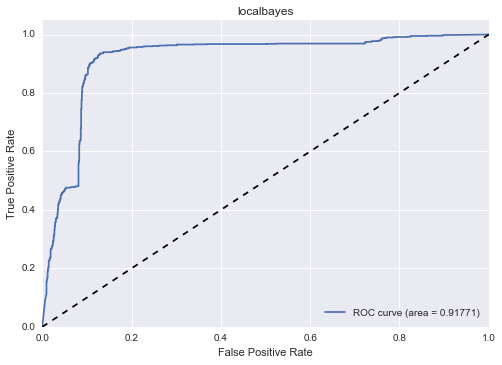

In [42]:
visual.roc_curve('localbayes', test_0_0, result['pred'])

In [12]:
# -*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""
The :mod:`elm` module implements the
Extreme Learning Machine Classifiers and Regressors (ELMClassifier,
ELMRegressor, SimpleELMRegressor, SimpleELMClassifier).
An Extreme Learning Machine (ELM) is a single layer feedforward
network with a random hidden layer components and ordinary linear
least squares fitting of the hidden->output weights by default.
[1][2]
References
----------
.. [1] http://www.extreme-learning-machines.org
.. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
          2006.
"""

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.linalg import pinv2

from sklearn.utils import as_float_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.preprocessing import LabelBinarizer

from random_layer import RandomLayer, MLPRandomLayer

__all__ = ["ELMRegressor",
           "ELMClassifier",
           "GenELMRegressor",
           "GenELMClassifier"]


# BaseELM class, regressor and hidden_layer attributes
# and provides defaults for docstrings
class BaseELM(BaseEstimator):
    """
    Base class for ELMs.
    Warning: This class should not be used directly.
    Use derived classes instead.
    """
    __metaclass__ = ABCMeta

    def __init__(self, hidden_layer, regressor):
        self.regressor = regressor
        self.hidden_layer = hidden_layer

    @abstractmethod
    def fit(self, X, y):
        """
        Fit the model using X, y as training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)
        Returns
        -------
        self : object
            Returns an instance of self.
        """

    @abstractmethod
    def predict(self, X):
        """
        Predict values using the model
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """


class GenELMRegressor(BaseELM, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.
    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]
    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))
    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed
    Attributes
    ----------
    `coefs_` : numpy array
        Fitted regression coefficients if no regressor supplied.
    `fitted_` : bool
        Flag set when fit has been called already.
    `hidden_activations_` : numpy array of shape [n_samples, n_hidden]
        Hidden layer activations for last input.
    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier
    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 regressor=None):

        super(GenELMRegressor, self).__init__(hidden_layer, regressor)

        self.coefs_ = None
        self.fitted_ = False
        self.hidden_activations_ = None

    def _fit_regression(self, y):
        """
        fit regression using pseudo-inverse
        or supplied regressor
        """
        if (self.regressor is None):
            self.coefs_ = safe_sparse_dot(pinv2(self.hidden_activations_), y)
        else:
            self.regressor.fit(self.hidden_activations_, y)

        self.fitted_ = True

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        # fit random hidden layer and compute the hidden layer activations
        self.hidden_activations_ = self.hidden_layer.fit_transform(X)

        # solve the regression from hidden activations to outputs
        self._fit_regression(as_float_array(y, copy=True))

        return self

    def _get_predictions(self):
        """get predictions using internal least squares/supplied regressor"""
        if (self.regressor is None):
            preds = safe_sparse_dot(self.hidden_activations_, self.coefs_)
        else:
            preds = self.regressor.predict(self.hidden_activations_)

        return preds

    def predict(self, X):
        """
        Predict values using the model
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (not self.fitted_):
            raise ValueError("ELMRegressor not fitted")

        # compute hidden layer activations
        self.hidden_activations_ = self.hidden_layer.transform(X)

        # compute output predictions for new hidden activations
        predictions = self._get_predictions()

        return predictions


class GenELMClassifier(BaseELM, ClassifierMixin):
    """
    GenELMClassifier is a classifier based on the Extreme Learning Machine.
    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]
    Parameters
    ----------
    `hidden_layer` : random_layer instance, optional
        (default=MLPRandomLayer(random_state=0))
    `binarizer` : LabelBinarizer, optional
        (default=LabelBinarizer(-1, 1))
    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed
    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels
    `genelm_regressor_` : ELMRegressor instance
        Performs actual fit of binarized values
    See Also
    --------
    RBFRandomLayer, MLPRandomLayer, ELMRegressor, ELMClassifier
    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
              Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """
    def __init__(self,
                 hidden_layer=MLPRandomLayer(random_state=0),
                 binarizer=LabelBinarizer(-1, 1),
                 regressor=None):

        super(GenELMClassifier, self).__init__(hidden_layer, regressor)

        self.binarizer = binarizer

        self.classes_ = None
        self.genelm_regressor_ = GenELMRegressor(hidden_layer, regressor)

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return self.genelm_regressor_.predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        self.genelm_regressor_.fit(X, y_bin)
        return self

    def predict(self, X):
        """Predict values using the model
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions


# ELMRegressor with default RandomLayer
class ELMRegressor(BaseEstimator, RegressorMixin):
    """
    ELMRegressor is a regressor based on the Extreme Learning Machine.
    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]
    ELMRegressor is a wrapper for an GenELMRegressor that uses a
    RandomLayer and passes the __init__ parameters through
    to the hidden layer generated by the fit() method.
    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer
    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation
    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation
    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation
        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.
    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func
    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_hidden, n_features]
    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed
    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.
    Attributes
    ----------
    `genelm_regressor_` : GenELMRegressor object
        Wrapped object that actually performs the fit.
    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier
    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None, random_state=None):

        self.n_hidden = n_hidden
        self.alpha = alpha
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args
        self.user_components = user_components
        self.rbf_width = rbf_width
        self.regressor = regressor

        self._genelm_regressor = None

    def _create_random_layer(self):
        """Pass init params to RandomLayer"""

        return RandomLayer(n_hidden=self.n_hidden,
                           alpha=self.alpha, random_state=self.random_state,
                           activation_func=self.activation_func,
                           activation_args=self.activation_args,
                           user_components=self.user_components,
                           rbf_width=self.rbf_width)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        rhl = self._create_random_layer()
        self._genelm_regressor = GenELMRegressor(hidden_layer=rhl,
                                                 regressor=self.regressor)
        self._genelm_regressor.fit(X, y)
        return self

    def predict(self, X):
        """
        Predict values using the model
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        if (self._genelm_regressor is None):
            raise ValueError("SimpleELMRegressor not fitted")

        return self._genelm_regressor.predict(X)


class ELMClassifier(ELMRegressor):
    """
    ELMClassifier is a classifier based on the Extreme Learning Machine.
    An Extreme Learning Machine (ELM) is a single layer feedforward
    network with a random hidden layer components and ordinary linear
    least squares fitting of the hidden->output weights by default.
    [1][2]
    ELMClassifier is an ELMRegressor subclass that first binarizes the
    data, then uses the superclass to compute the decision function that
    is then unbinarized to yield the prediction.
    The params for the RandomLayer used in the input transform are
    exposed in the ELMClassifier constructor.
    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer
    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation
        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.
    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func
    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.
    Attributes
    ----------
    `classes_` : numpy array of shape [n_classes]
        Array of class labels
    See Also
    --------
    RandomLayer, RBFRandomLayer, MLPRandomLayer,
    GenELMRegressor, GenELMClassifier, ELMClassifier
    References
    ----------
    .. [1] http://www.extreme-learning-machines.org
    .. [2] G.-B. Huang, Q.-Y. Zhu and C.-K. Siew, "Extreme Learning Machine:
          Theory and Applications", Neurocomputing, vol. 70, pp. 489-501,
              2006.
    """

    def __init__(self, n_hidden=20, alpha=0.5, rbf_width=1.0,
                 activation_func='tanh', activation_args=None,
                 user_components=None, regressor=None,
                 binarizer=LabelBinarizer(-1, 1),
                 random_state=None):

        super(ELMClassifier, self).__init__(n_hidden=n_hidden,
                                            alpha=alpha,
                                            random_state=random_state,
                                            activation_func=activation_func,
                                            activation_args=activation_args,
                                            user_components=user_components,
                                            rbf_width=rbf_width,
                                            regressor=regressor)

        self.classes_ = None
        self.binarizer = binarizer

    def decision_function(self, X):
        """
        This function return the decision function values related to each
        class on an array of test vectors X.
        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
        Returns
        -------
        C : array of shape [n_samples, n_classes] or [n_samples,]
            Decision function values related to each class, per sample.
            In the two-class case, the shape is [n_samples,]
        """
        return super(ELMClassifier, self).predict(X)

    def fit(self, X, y):
        """
        Fit the model using X, y as training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape [n_samples, n_outputs]
            Target values (class labels in classification, real numbers in
            regression)
        Returns
        -------
        self : object
            Returns an instance of self.
        """
        self.classes_ = np.unique(y)

        y_bin = self.binarizer.fit_transform(y)

        super(ELMClassifier, self).fit(X, y_bin)

        return self

    def predict(self, X):
        """
        Predict values using the model
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
        Returns
        -------
        C : numpy array of shape [n_samples, n_outputs]
            Predicted values.
        """
        raw_predictions = self.decision_function(X)
        class_predictions = self.binarizer.inverse_transform(raw_predictions)

        return class_predictions

    def score(self, X, y):
        """Force use of accuracy score since we don't inherit
           from ClassifierMixin"""

        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X))

In [13]:
#-*- coding: utf8
# Author: David C. Lambert [dcl -at- panix -dot- com]
# Copyright(c) 2013
# License: Simple BSD

"""The :mod:`random_layer` module
implements Random Layer transformers.

Random layers are arrays of hidden unit activations that are
random functions of input activation values (dot products for simple
activation functions, distances from prototypes for radial basis
functions).

They are used in the implementation of Extreme Learning Machines (ELMs),
but can be used as a general input mapping.
"""

from abc import ABCMeta, abstractmethod

from math import sqrt

import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import cdist, pdist, squareform

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.base import BaseEstimator, TransformerMixin

__all__ = ['RandomLayer',
           'MLPRandomLayer',
           'RBFRandomLayer',
           'GRBFRandomLayer',
           ]


class BaseRandomLayer(BaseEstimator, TransformerMixin):
    """Abstract Base Class for random  layers"""
    __metaclass__ = ABCMeta

    _internal_activation_funcs = dict()

    @classmethod
    def activation_func_names(cls):
        """Get list of internal activation function names"""
        return cls._internal_activation_funcs.keys()

    # take n_hidden and random_state, init components_ and
    # input_activations_
    def __init__(self, n_hidden=20, random_state=0, activation_func=None,
                 activation_args=None):

        self.n_hidden = n_hidden
        self.random_state = random_state
        self.activation_func = activation_func
        self.activation_args = activation_args

        self.components_ = dict()
        self.input_activations_ = None

        # keyword args for internally defined funcs
        self._extra_args = dict()

    @abstractmethod
    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

    @abstractmethod
    def _compute_input_activations(self, X):
        """Compute input activations given X"""

    # compute input activations and pass them
    # through the hidden layer transfer functions
    # to compute the transform
    def _compute_hidden_activations(self, X):
        """Compute hidden activations given X"""

        self._compute_input_activations(X)

        acts = self.input_activations_

        if (callable(self.activation_func)):
            args_dict = self.activation_args if (self.activation_args) else {}
            X_new = self.activation_func(acts, **args_dict)
        else:
            func_name = self.activation_func
            func = self._internal_activation_funcs[func_name]

            X_new = func(acts, **self._extra_args)

        return X_new

    # perform fit by generating random components based
    # on the input array
    def fit(self, X, y=None):
        """Generate a random hidden layer.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape [n_samples, n_features]
            Training set: only the shape is used to generate random component
            values for hidden units

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        self
        """
        X = check_array(X)

        self._generate_components(X)

        return self

    # perform transformation by calling compute_hidden_activations
    # (which will normally call compute_input_activations first)
    def transform(self, X, y=None):
        """Generate the random hidden layer's activations given X as input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            Data to transform

        y : is not used: placeholder to allow for usage in a Pipeline.

        Returns
        -------
        X_new : numpy array of shape [n_samples, n_components]
        """
        X = check_array(X)

        if (self.components_ is None):
            raise ValueError('No components initialized')

        return self._compute_hidden_activations(X)


class RandomLayer(BaseRandomLayer):
    """RandomLayer is a transformer that creates a feature mapping of the
    inputs that corresponds to a layer of hidden units with randomly
    generated components.

    The transformed values are a specified function of input activations
    that are a weighted combination of dot product (multilayer perceptron)
    and distance (rbf) activations:

      input_activation = alpha * mlp_activation + (1-alpha) * rbf_activation

      mlp_activation(x) = dot(x, weights) + bias
      rbf_activation(x) = rbf_width * ||x - center||/radius

      alpha and rbf_width are specified by the user

      weights and biases are taken from normal distribution of
      mean 0 and sd of 1

      centers are taken uniformly from the bounding hyperrectangle
      of the inputs, and radii are max(||x-c||)/sqrt(n_centers*2)

    The input activation is transformed by a transfer function that defaults
    to numpy.tanh if not specified, but can be any callable that returns an
    array of the same shape as its argument (the input activation array, of
    shape [n_samples, n_hidden]).  Functions provided are 'sine', 'tanh',
    'tribas', 'inv_tribas', 'sigmoid', 'hardlim', 'softlim', 'gaussian',
    'multiquadric', or 'inv_multiquadric'.

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate

    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation

    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation

    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_features, n_hidden]

    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation

        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribas',
        'sigmoid', 'hardlim', 'softlim', 'gaussian', 'multiquadric',
        'inv_multiquadric' or a callable.  If None is given, 'tanh'
        will be used.

        If a callable is given, it will be used to compute the activations.

    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func

    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

    Attributes
    ----------
    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing dot(x, hidden_weights) + bias for all samples

    `components_` : dictionary containing two keys:
        `bias_weights_`   : numpy array of shape [n_hidden]
        `hidden_weights_` : numpy array of shape [n_features, n_hidden]

    See Also
    --------
    """
    # triangular activation function
    _tribas = (lambda x: np.clip(1.0 - np.fabs(x), 0.0, 1.0))

    # inverse triangular activation function
    _inv_tribas = (lambda x: np.clip(np.fabs(x), 0.0, 1.0))

    # sigmoid activation function
    _sigmoid = (lambda x: 1.0/(1.0 + np.exp(-x)))

    # hard limit activation function
    _hardlim = (lambda x: np.array(x > 0.0, dtype=float))

    _softlim = (lambda x: np.clip(x, 0.0, 1.0))

    # gaussian RBF
    _gaussian = (lambda x: np.exp(-pow(x, 2.0)))

    # multiquadric RBF
    _multiquadric = (lambda x:
                     np.sqrt(1.0 + pow(x, 2.0)))

    # inverse multiquadric RBF
    _inv_multiquadric = (lambda x:
                         1.0/(np.sqrt(1.0 + pow(x, 2.0))))

    # internal activation function table
    _internal_activation_funcs = {'sine': np.sin,
                                  'tanh': np.tanh,
                                  'tribas': _tribas,
                                  'inv_tribas': _inv_tribas,
                                  'sigmoid': _sigmoid,
                                  'softlim': _softlim,
                                  'hardlim': _hardlim,
                                  'gaussian': _gaussian,
                                  'multiquadric': _multiquadric,
                                  'inv_multiquadric': _inv_multiquadric,
                                  }

    def __init__(self, n_hidden=20, alpha=0.5, random_state=None,
                 activation_func='tanh', activation_args=None,
                 user_components=None, rbf_width=1.0):

        super(RandomLayer, self).__init__(n_hidden=n_hidden,
                                          random_state=random_state,
                                          activation_func=activation_func,
                                          activation_args=activation_args)

        if (isinstance(self.activation_func, str)):
            func_names = self._internal_activation_funcs.keys()
            if (self.activation_func not in func_names):
                msg = "unknown activation function '%s'" % self.activation_func
                raise ValueError(msg)

        self.alpha = alpha
        self.rbf_width = rbf_width
        self.user_components = user_components

        self._use_mlp_input = (self.alpha != 0.0)
        self._use_rbf_input = (self.alpha != 1.0)

    def _get_user_components(self, key):
        """Look for given user component"""
        try:
            return self.user_components[key]
        except (TypeError, KeyError):
            return None

    def _compute_radii(self):
        """Generate RBF radii"""

        # use supplied radii if present
        radii = self._get_user_components('radii')

        # compute radii
        if (radii is None):
            centers = self.components_['centers']

            n_centers = centers.shape[0]
            max_dist = np.max(pairwise_distances(centers))
            radii = np.ones(n_centers) * max_dist/sqrt(2.0 * n_centers)

        self.components_['radii'] = radii

    def _compute_centers(self, X, sparse, rs):
        """Generate RBF centers"""

        # use supplied centers if present
        centers = self._get_user_components('centers')

        # use points taken uniformly from the bounding
        # hyperrectangle
        if (centers is None):
            n_features = X.shape[1]

            if (sparse):
                fxr = xrange(n_features)
                cols = [X.getcol(i) for i in fxr]

                min_dtype = X.dtype.type(1.0e10)
                sp_min = lambda col: np.minimum(min_dtype, np.min(col.data))
                min_Xs = np.array(map(sp_min, cols))

                max_dtype = X.dtype.type(-1.0e10)
                sp_max = lambda col: np.maximum(max_dtype, np.max(col.data))
                max_Xs = np.array(map(sp_max, cols))
            else:
                min_Xs = X.min(axis=0)
                max_Xs = X.max(axis=0)

            spans = max_Xs - min_Xs
            ctrs_size = (self.n_hidden, n_features)
            centers = min_Xs + spans * rs.uniform(0.0, 1.0, ctrs_size)

        self.components_['centers'] = centers

    def _compute_biases(self, rs):
        """Generate MLP biases"""

        # use supplied biases if present
        biases = self._get_user_components('biases')
        if (biases is None):
            b_size = self.n_hidden
            biases = rs.normal(size=b_size)

        self.components_['biases'] = biases

    def _compute_weights(self, X, rs):
        """Generate MLP weights"""

        # use supplied weights if present
        weights = self._get_user_components('weights')
        if (weights is None):
            n_features = X.shape[1]
            hw_size = (n_features, self.n_hidden)
            weights = rs.normal(size=hw_size)

        self.components_['weights'] = weights

    def _generate_components(self, X):
        """Generate components of hidden layer given X"""

        rs = check_random_state(self.random_state)
        if (self._use_mlp_input):
            self._compute_biases(rs)
            self._compute_weights(X, rs)

        if (self._use_rbf_input):
            self._compute_centers(X, sp.issparse(X), rs)
            self._compute_radii()

    def _compute_input_activations(self, X):
        """Compute input activations given X"""

        n_samples = X.shape[0]

        mlp_acts = np.zeros((n_samples, self.n_hidden))
        if (self._use_mlp_input):
            b = self.components_['biases']
            w = self.components_['weights']
            mlp_acts = self.alpha * (safe_sparse_dot(X, w) + b)

        rbf_acts = np.zeros((n_samples, self.n_hidden))
        if (self._use_rbf_input):
            radii = self.components_['radii']
            centers = self.components_['centers']
            scale = self.rbf_width * (1.0 - self.alpha)
            rbf_acts = scale * cdist(X, centers)/radii

        self.input_activations_ = mlp_acts + rbf_acts


class MLPRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
       to 1.0 for MLP activations only"""

    def __init__(self, n_hidden=20, random_state=None,
                 activation_func='tanh', activation_args=None,
                 weights=None, biases=None):

        user_components = {'weights': weights, 'biases': biases}
        super(MLPRandomLayer, self).__init__(n_hidden=n_hidden,
                                             random_state=random_state,
                                             activation_func=activation_func,
                                             activation_args=activation_args,
                                             user_components=user_components,
                                             alpha=1.0)


class RBFRandomLayer(RandomLayer):
    """Wrapper for RandomLayer with alpha (mixing coefficient) set
       to 0.0 for RBF activations only"""

    def __init__(self, n_hidden=20, random_state=None,
                 activation_func='gaussian', activation_args=None,
                 centers=None, radii=None, rbf_width=1.0):

        user_components = {'centers': centers, 'radii': radii}
        super(RBFRandomLayer, self).__init__(n_hidden=n_hidden,
                                             random_state=random_state,
                                             activation_func=activation_func,
                                             activation_args=activation_args,
                                             user_components=user_components,
                                             rbf_width=rbf_width,
                                             alpha=0.0)


class GRBFRandomLayer(RBFRandomLayer):
    """Random Generalized RBF Hidden Layer transformer

    Creates a layer of radial basis function units where:

       f(a), s.t. a = ||x-c||/r

    with c the unit center
    and f() is exp(-gamma * a^tau) where tau and r are computed
    based on [1]

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate, ignored if centers are provided

    `grbf_lambda` : float, optional (default=0.05)
        GRBF shape parameter

    `gamma` : {int, float} optional (default=1.0)
        Width multiplier for GRBF distance argument

    `centers` : array of shape (n_hidden, n_features), optional (default=None)
        If provided, overrides internal computation of the centers

    `radii` : array of shape (n_hidden),  optional (default=None)
        If provided, overrides internal computation of the radii

    `use_exemplars` : bool, optional (default=False)
        If True, uses random examples from the input to determine the RBF
        centers, ignored if centers are provided

    `random_state`  : int or RandomState instance, optional (default=None)
        Control the pseudo random number generator used to generate the
        centers at fit time, ignored if centers are provided

    Attributes
    ----------
    `components_` : dictionary containing two keys:
        `radii_`   : numpy array of shape [n_hidden]
        `centers_` : numpy array of shape [n_hidden, n_features]

    `input_activations_` : numpy array of shape [n_samples, n_hidden]
        Array containing ||x-c||/r for all samples

    See Also
    --------
    ELMRegressor, ELMClassifier, SimpleELMRegressor, SimpleELMClassifier,
    SimpleRandomLayer

    References
    ----------
    .. [1] Fernandez-Navarro, et al, "MELM-GRBF: a modified version of the
              extreme learning machine for generalized radial basis function
              neural networks", Neurocomputing 74 (2011), 2502-2510

    """
    # def _grbf(acts, taus):
    #     """GRBF activation function"""

    #     return np.exp(np.exp(-pow(acts, taus)))

    _grbf = (lambda acts, taus: np.exp(np.exp(-pow(acts, taus))))

    _internal_activation_funcs = {'grbf': _grbf}

    def __init__(self, n_hidden=20, grbf_lambda=0.001,
                 centers=None, radii=None, random_state=None):

        super(GRBFRandomLayer, self).__init__(n_hidden=n_hidden,
                                              activation_func='grbf',
                                              centers=centers, radii=radii,
                                              random_state=random_state)

        self.grbf_lambda = grbf_lambda
        self.dN_vals = None
        self.dF_vals = None
        self.tau_vals = None

    # get centers from superclass, then calculate tau_vals
    # according to ref [1]
    def _compute_centers(self, X, sparse, rs):
        """Generate centers, then compute tau, dF and dN vals"""

        super(GRBFRandomLayer, self)._compute_centers(X, sparse, rs)

        centers = self.components_['centers']
        sorted_distances = np.sort(squareform(pdist(centers)))
        self.dF_vals = sorted_distances[:, -1]
        self.dN_vals = sorted_distances[:, 1]/100.0
        #self.dN_vals = 0.0002 * np.ones(self.dF_vals.shape)

        tauNum = np.log(np.log(self.grbf_lambda) /
                        np.log(1.0 - self.grbf_lambda))

        tauDenom = np.log(self.dF_vals/self.dN_vals)

        self.tau_vals = tauNum/tauDenom

        self._extra_args['taus'] = self.tau_vals

    # get radii according to ref [1]
    def _compute_radii(self):
        """Generate radii"""

        denom = pow(-np.log(self.grbf_lambda), 1.0/self.tau_vals)
        self.components_['radii'] = self.dF_vals/denom
